In [92]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [93]:
%pylab inline
%load_ext autoreload
%autoreload 2
# from paper_visualizations import * 
from PixelEM import * 
# from test_sample import test_sample_obj
import json

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/jlee782/.local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['box', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [94]:
df = pd.read_csv("pixel_em/MV_PRJ_table.csv")
df = df.rename(columns={"MV_precision":"P [MV]",
                       "MV_recall":"R [MV]",
                       "MV_jaccard":"J [MV]"})
for mode in  ["GT","isoGT","GTLSA","isoGTLSA","basic"]:
    data =  pd.read_csv("pixel_em/{}_ground_truth_full_PRJ_table.csv".format(mode))
    data = data.rename(columns={"EM_precision":"P [{}]".format(mode),
                       "EM_recall":"R [{}]".format(mode),
                       "EM_jaccard":"J [{}]".format(mode),})
    df = df.merge(data)

In [95]:
metric_keys=[u'P [MV]',u'R [MV]', u'J [MV]', u'P [GT]', u'R [GT]', u'J [GT]', u'P [isoGT]',
       u'R [isoGT]', u'J [isoGT]', u'P [GTLSA]', u'R [GTLSA]', u'J [GTLSA]',
       u'P [isoGTLSA]', u'R [isoGTLSA]', u'J [isoGTLSA]', u'P [basic]',
       u'R [basic]', u'J [basic]']

In [96]:
algo_df.head()

NameError: name 'algo_df' is not defined

In [97]:
algo_df = pd.read_csv("pixel_em/basic_ground_truth_full_PRJ_table.csv",index_col=0)
mv_df = pd.read_csv("pixel_em/MV_PRJ_table.csv")
mv_df = mv_df.rename(columns={'MV_precision':"P [MV]",
                              "MV_recall":"R [MV]",
                               "MV_jaccard":"J [MV]"})
# # mv_df["thresh"]=0
# # mv_df["algorithm"]="MV"

# df = pd.concat([algo_df,mv_df])
algo_lst=["basic","GT","isoGT","GTLSA","isoGTLSA","AW","isoAW"]
# newdf = mv_df 
# for algo in algo_lst:
#     data = algo_df[algo_df["algorithm"]==algo].rename(columns={"precision":"P [{}]".format(algo),
#                                             "recall":"R [{}]".format(algo),
#                                             "jaccard":"J [{}]".format(algo)})
#     data = data.drop('algorithm',axis=1)
#     newdf = newdf.merge(data)

# newdf = newdf.drop_duplicates()



# GTLSA_Fixed = GTLSA_Fixed.rename(columns={"EM_precision":"P [GTLSA PixTile]",
#                             "EM_recall":"R [GTLSA PixTile]",
#                             "EM_jaccard":"J [GTLSA PixTile]"})
# isoGTLSA_Fixed = isoGTLSA_Fixed.rename(columns={"EM_precision":"P [isoGTLSA PixTile]",
#                             "EM_recall":"R [isoGTLSA PixTile]",
#                             "EM_jaccard":"J [isoGTLSA PixTile]"})

# newdf = newdf.merge(GTLSA_Fixed).merge(isoGTLSA_Fixed)

In [98]:
df[df["thresh"]==0].mean()[metric_keys]

P [MV]          0.947492
R [MV]          0.929748
J [MV]          0.883542
P [GT]          0.917430
R [GT]          0.969895
J [GT]          0.891915
P [isoGT]       0.946235
R [isoGT]       0.954794
J [isoGT]       0.905406
P [GTLSA]       0.287162
R [GTLSA]       0.948512
J [GTLSA]       0.281660
P [isoGTLSA]    0.933243
R [isoGTLSA]    0.950749
J [isoGTLSA]    0.889066
P [basic]       0.946480
R [basic]       0.936759
J [basic]       0.889463
dtype: float64

In [99]:
df.head()

,num_workers,sample_num,objid,P [MV],R [MV],J [MV],thresh,P [GT],R [GT],J [GT],...,J [isoGT],P [GTLSA],R [GTLSA],J [GTLSA],P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],P [basic],R [basic],J [basic]
0,5,0,1,0.977603,0.980179,0.958651,-4,0.925597,0.990605,0.917542,...,0.894056,0.084315,0.983540,0.084196,0.896327,0.997174,0.894056,0.977075,0.981515,0.959421
1,5,0,1,0.977603,0.980179,0.958651,-2,0.925597,0.990605,0.917542,...,0.912494,0.082767,0.962764,0.082503,0.960338,0.990376,0.951458,0.977603,0.980179,0.958651
2,5,0,1,0.977603,0.980179,0.958651,0,0.969400,0.986060,0.956295,...,0.956627,0.082767,0.962764,0.082503,0.978832,0.978384,0.958112,0.977603,0.980179,0.958651
3,5,0,1,0.977603,0.980179,0.958651,2,0.977603,0.980179,0.958651,...,0.947850,0.994513,0.920677,0.916024,0.994513,0.920677,0.916024,0.977603,0.980179,0.958651
4,5,0,1,0.977603,0.980179,0.958651,4,0.977603,0.980179,0.958651,...,0.916024,0.994513,0.920677,0.916024,0.994513,0.920677,0.916024,0.979174,0.978613,0.958659


### Performance as it varies with number of workers

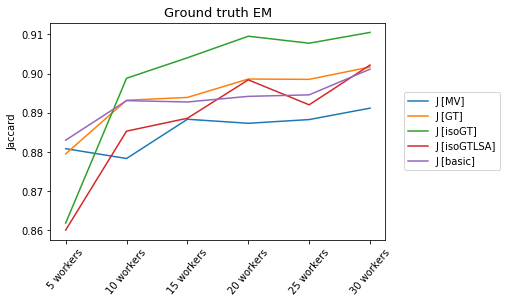

In [100]:
Nworker_performance = df.groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM",fontsize=13)

In [9]:
def plot_PRcurve(objid,num_worker,sample_num=0):
    objdf = df[(df["num_workers"]==num_worker)&(df["sample_num"]==sample_num)&(df["objid"]==objid)]
    plt.figure()
    for algo in ['basic','GT','isoGT','GTLSA','isoGTLSA']:
        x= objdf["P [{}]".format(algo)]
        y = objdf["R [{}]".format(algo)]
        if len(x)<=0:
            return
        sortedx, sortedy = zip(*sorted(zip(x, y)))
        plt.plot(sortedx,sortedy,'.-',label=algo)
    plt.xlabel("Precision",fontsize=13)
    plt.ylabel("Recall",fontsize=13)
    plt.legend(loc="bottom left")
    plt.title("{}worker_rand{} [obj {};N={}]".format(num_worker,sample_num,objid,len(objdf)))

# Greedy Algo Results

In [ ]:
from glob import glob 
import pandas as pd

globfnames = glob("greedy_result_*.csv")
greedy_df = pd.read_csv(globfnames[0],index_col=0)
for fname in globfnames[1:]: 
    greedy_df = greedy_df.append(pd.read_csv(fname,index_col=0))

assert len(greedy_df)==31*44*5

greedy_df.to_csv("all_greedy_result.csv")

In [87]:
greedy_df = pd.read_csv("all_greedy_result.csv",index_col=0)

ground_truth_greedy_df = pd.read_csv("ground_truth_greedy_result.csv")
greedy_df = greedy_df.append(ground_truth_greedy_df)
worker_frac_greedy_df = pd.read_csv("greedy_result_worker_fraction.csv")
greedy_df = greedy_df.append(worker_frac_greedy_df)

greedy_df["num_workers"] = greedy_df["sample"].apply(lambda x: int(x.split("workers")[0]))

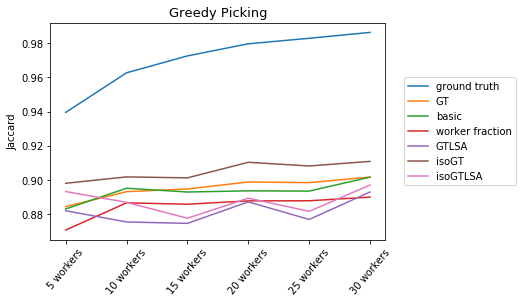

In [101]:
Nworker_performance = greedy_df.groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


In [7]:
# algo_lst=["basic","GT","isoGT","GTLSA","isoGTLSA"]

# for algo in algo_lst:
#     data = df[df["algo"]==algo].rename(columns={"p":"P [{}]".format(algo),
#                                             "r":"R [{}]".format(algo),
#                                             "j":"J [{}]".format(algo)})
#     newdf = newdf.merge(data)